In [1]:
!pip install git+https://github.com/williamedwardhahn/mpcr
!pip install flashtorch
!pip install barbar
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-_hx0coru
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-_hx0coru
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7325 sha256=e2a4d8141bd8e7d5e6d684cf8583776211a556119c7132405fd797403e45f518
  Stored in directory: /tmp/pip-ephem-wheel-cache-tt7o1dt8/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=7b7813690937719e50eaa0d83f96b80d78715d89cded9f44fa3f2f310dc41dee
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create new folder on your google drive like below:

In [3]:
data_dir = '/content/drive/MyDrive/Dataset 1/MnBs/'

In [4]:
os.chdir(data_dir)

In [5]:
dataset_labels =["Butterflies", "Moths"] #<--- Replace with your labels 

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [7]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'train': 80, 'valid': 20}

In [9]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

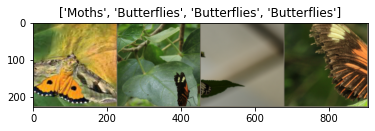

In [11]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[7:11]
classes = classes[7:11] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [13]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [15]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [16]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [17]:
model.conv1 #model is set up for 3 color channel inputs

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change first layer to single channel inputs

In [18]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

In [19]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 0.24
Valid  Acc: 0.90
#######################
Epoch:  2 / 30
Train  Acc: 0.88
Valid  Acc: 1.00
#######################
Epoch:  3 / 30
Train  Acc: 0.90
Valid  Acc: 1.00
#######################
Epoch:  4 / 30
Train  Acc: 0.95
Valid  Acc: 1.00
#######################
Epoch:  5 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  6 / 30
Train  Acc: 0.96
Valid  Acc: 1.00
#######################
Epoch:  7 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  8 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  9 / 30
Train  Acc: 0.99
Valid  Acc: 1.00
#######################
Epoch:  10 / 30
Train  Acc: 0.99
Valid  Acc: 1.00
#######################
Epoch:  11 / 30
Train  Acc: 0.98
Valid  Acc: 1.00
#######################
Epoch:  12 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  13 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  14 / 30
Train  Acc: 1.00
Valid  Acc: 1.

In [20]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    True_positive =0
    True_negative = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            
            imshow(inputs.cpu().data[j],title1)

            if dataset_labels[labels[j]]== "Tumor":
              True_positive += dataset_labels[preds[j]]== dataset_labels[labels[j]]
            if dataset_labels[labels[j]] == "Healthy":
              True_negative += dataset_labels[preds[j]]== dataset_labels[labels[j]]



            if index == num_images:
                return True_positive, True_negative

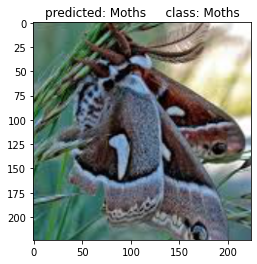

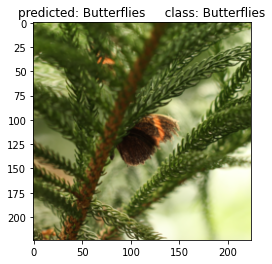

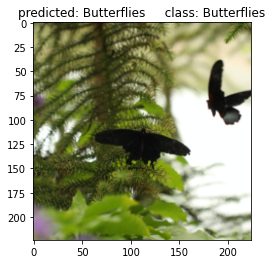

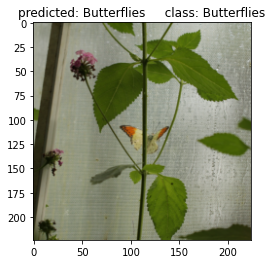

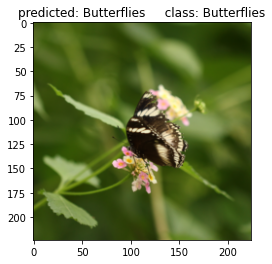

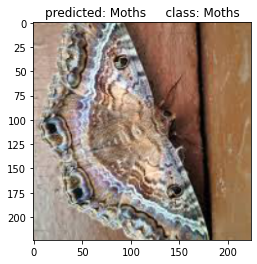

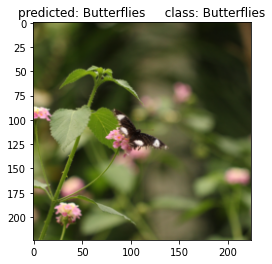

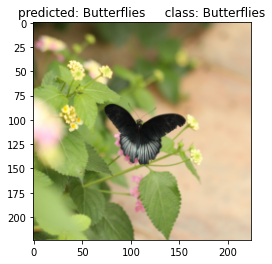

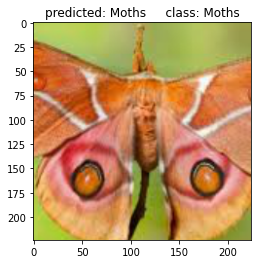

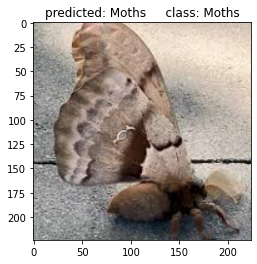

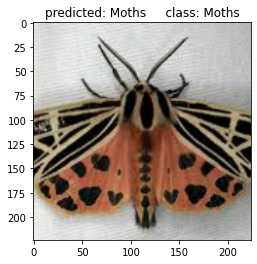

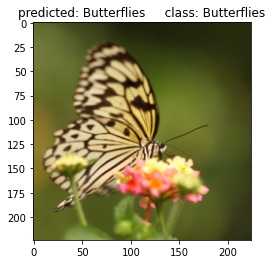

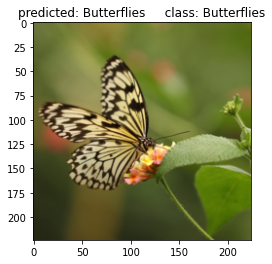

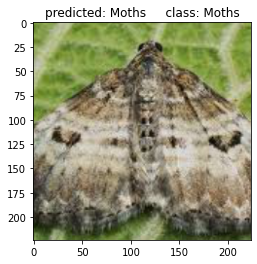

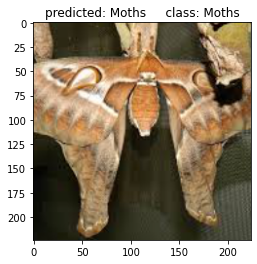

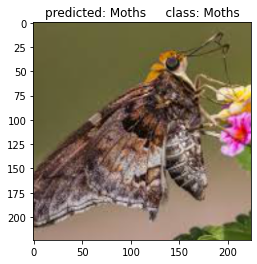

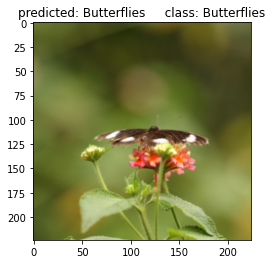

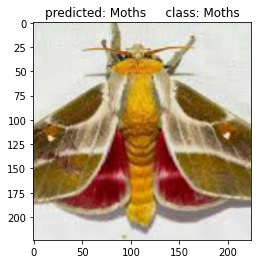

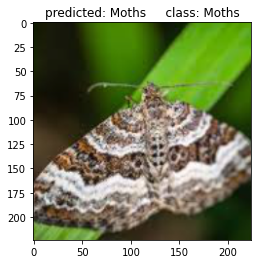

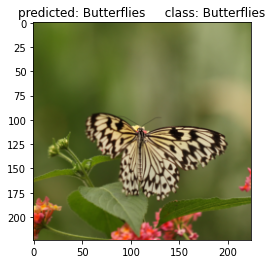

0 0


In [21]:
TP, TN = visualize_model(model,20)
print(TP, TN)

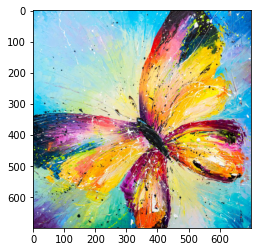

In [23]:
image = io.imread('https://www.gallerytoday.com/41899/butterfly.jpg')
plt.imshow(image);

In [24]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [26]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [27]:
print('predicted: ' + dataset_labels[preds])

predicted: Butterflies


In [28]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [31]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [32]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [33]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[10,  0],
       [ 0, 10]])

Calculate each of the following:

Accuracy (ACC)
The percentage of correctly identified true and false samples.

True positive (TP)
The number of correctly identified samples. 

True negative (TN)
The number of correctly identified negative samples.
 
False positive (FP)
The number of wrongly identified samples, i.e., a commonly called a "false alarm". 
 
False negative (FN)
The number of wrongly identified negative samples. 

Recall (REC)
This metric is also frequently called sensitivity, probability of detection and true positive rate, and it is the ratio of samples that are correctly identified as positive among all existing positive samples.
 
Precision (PREC)
This metric is also frequently called the positive predictive value, and shows the ratio of samples that are correctly identified as positive.

Specificity (SPEC)
This metric is frequently called the true negative rate, and shows the ratio of negatives that are correctly identified as such.
 
F1 score (F1)
A measure of a test’s accuracy by calculating the harmonic mean of the precision and recall.


In [34]:
cm[0,0] #True Negative

10

In [35]:
cm[1,1] #True Positive

10

In [36]:
cm[0,1] #False Positive

0

In [37]:
cm[1,0] #False Negative

0

In [38]:
accuracy = (cm[0,0]+ cm[1,1])/20 # Accuracy
print(accuracy)

1.0


In [39]:
precision = cm[1,1]/10  #Precision
print(precision)

1.0


In [40]:
recall = cm[1,1]/(cm[1,1]+ cm[1,0]) #recall 
print(recall)

1.0


In [41]:
F_measure =(2*precision*recall)/(precision+recall)
print(F_measure)

1.0
